# Modelling

### Imports

In [76]:
# Standard library imports
from pathlib import Path
from datetime import datetime
from operator import add, itemgetter
import os

# Third party imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LogisticRegression
from sklearn.svm import SVR, SVC
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    accuracy_score,
    confusion_matrix,
    classification_report
)
from sklearn.base import clone
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB

In [2]:
%matplotlib inline
sns.set_style('whitegrid')

### Read in data

In [3]:
data_path = Path('../data')
processed_prem_path = os.path.join(data_path, 'processed', 'processed_prem_fixtures.csv')
prem_fixtures = pd.read_csv(processed_prem_path)

In [4]:
prem_fixtures.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3698 entries, 0 to 3697
Data columns (total 31 columns):
date                             3698 non-null object
time                             3698 non-null object
competition                      3698 non-null object
home_team_id                     3698 non-null int64
home_team                        3698 non-null object
away_team_id                     3698 non-null int64
away_team                        3698 non-null object
home_goals                       3698 non-null float64
away_goals                       3698 non-null float64
relative_score                   3698 non-null float64
winner                           3698 non-null object
home_average_conceded            3498 non-null float64
away_average_conceded            3498 non-null float64
home_average_scored              3498 non-null float64
away_average_scored              3498 non-null float64
home_games_played                3698 non-null float64
away_games_played      

## Create features

The data at the beginning of the season provides a lot of uncertainty as many of the features I created are based on what has happened in the season up till the date of the fixture. I'm going to remove the first 5 games for each team in each of the seasons to get a more informed set of information. 

In [5]:
home_team_later_fixtures = prem_fixtures['home_games_played'] > 5
away_team_later_fixtures = prem_fixtures['away_games_played'] > 5
prem_fixtures = prem_fixtures[home_team_later_fixtures & away_team_later_fixtures]

Often the importance of statistics will be the difference in the statistics between the two teams playing. For example, if a team has an average win percentage of 60% this may look quite good when compared to a team that wins 0% of their games but is less impressive if they're facing a team that wins 100% of the time.

For this reason I want to calculate relative statistics between some of the features to find the difference between the teams.

In [6]:
def get_relative_statistic(fixtures, feature, lower_better):
    """
    Create relative statistics columns from features about each team in
    fixture. Params:
    - fixtures: pd.DataFrame
    - feature: Statistic to calculate relative statistics from.
    - lower_better: Bool, True if a lower value is better for the statistic.
    """
    # Get home and away stats
    home_away = ('home', 'away')
    columns = {prefix: '_'.join([prefix, feature]) for prefix in home_away}
    
    # Reset index to avoid concat issue
    new_fixtures = fixtures.reset_index(drop=True)
    
    # Calculate relative stat
    sign = -1 if lower_better else 1
    relative_stat = sign * (fixtures[columns['home']] - fixtures[columns['away']])
    relative_stat = relative_stat.rename('_'.join(['relative', feature]))

    return pd.concat([fixtures, relative_stat], axis=1)

In [7]:
lower_better_statistics = (
    'league_position',
    'average_conceded',
    'overall_average_conceded',
)
higher_better_statistics = (
    'average_scored',
    'average_points',
    'form',
    'overall_average_scored',
    'overall_average_points',
    'overall_form',
)
for stat in higher_better_statistics:
    prem_fixtures = get_relative_statistic(prem_fixtures, stat, False)
for stat in lower_better_statistics:
    prem_fixtures = get_relative_statistic(prem_fixtures, stat, True)

I think an important feature to consider is how both teams attacks interact with the oppositions defence. Teams with weak attacks will struggle to score against teams with strong defences.

I will create interaction terms for to measure the interaction between attack and defence based on each teams average scored and conceded. I will create terms for teams scored/conceded when playing at home/away and also overall.

In [8]:
# Interaction terms
prem_fixtures['attack_defence_interaction'] = (
    prem_fixtures['home_average_scored'] * prem_fixtures['away_average_conceded'])
prem_fixtures['defence_attack_interaction'] = (
    prem_fixtures['away_average_scored'] * prem_fixtures['home_average_conceded'])
prem_fixtures['overall_attack_defence_interaction'] = (
    prem_fixtures['home_overall_average_scored'] * prem_fixtures['away_overall_average_conceded'])
prem_fixtures['overall_defence_attack_interaction'] = (
    prem_fixtures['away_overall_average_scored'] * prem_fixtures['home_overall_average_conceded'])

We can again create relative statistics between these to highlight the difference between the two teams.

In [9]:
prem_fixtures['relative_att_def_interaction'] = (
    prem_fixtures['attack_defence_interaction'] - prem_fixtures['defence_attack_interaction'])
prem_fixtures['relative_overall_att_def_interaction'] = (
    prem_fixtures['overall_attack_defence_interaction'] - prem_fixtures['overall_defence_attack_interaction'])

## EDA

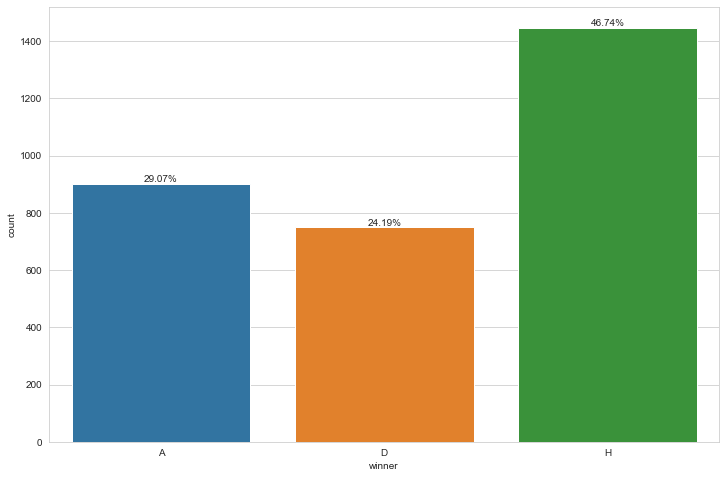

In [10]:
plt.figure(figsize=(12, 8))
ax = sns.countplot(prem_fixtures['winner'])

for p in ax.patches:
    count = p.get_height()
    percentage =  100*count/len(prem_fixtures)
    p.get_x()+p.get_width()/2
    ax.annotate(f'{percentage:.2f}%', (p.get_x()+p.get_width()/2, count), ha='center', va='bottom')

We see that teams playing at home are more likely to win. This could be due to a variety of reasons, having the home crowd advantage, referee bias, pitch familiarity etc.

In [11]:
prem_fixtures.columns

Index(['date', 'time', 'competition', 'home_team_id', 'home_team',
       'away_team_id', 'away_team', 'home_goals', 'away_goals',
       'relative_score', 'winner', 'home_average_conceded',
       'away_average_conceded', 'home_average_scored', 'away_average_scored',
       'home_games_played', 'away_games_played', 'home_league_position',
       'away_league_position', 'home_average_points', 'away_average_points',
       'home_overall_average_conceded', 'away_overall_average_conceded',
       'home_overall_average_scored', 'away_overall_average_scored',
       'home_overall_average_points', 'away_overall_average_points',
       'home_form', 'home_overall_form', 'away_form', 'away_overall_form',
       'relative_average_scored', 'relative_average_points', 'relative_form',
       'relative_overall_average_scored', 'relative_overall_average_points',
       'relative_overall_form', 'relative_league_position',
       'relative_average_conceded', 'relative_overall_average_conceded',
       

In [12]:
non_informative_columns = [
    'date', 'time', 'competition', 'home_team_id', 'home_team',
    'away_team_id', 'away_team', 'home_goals', 'away_goals',
    'winner', 'home_games_played', 'away_games_played'
]

Using Spearmans rank we can determine the features with the best correlation with the result. First, we will need to give the result a discrete encoding and then we can calculate Pearson correlation.

In [13]:
prem_fixtures['winner_rank'] = prem_fixtures['winner'].map({'A': 0, 'D': 1, 'H': 2})
prem_fixtures.drop(
    non_informative_columns + ['relative_score'],
    axis=1).corr().abs()['winner_rank'].sort_values(ascending=False)

winner_rank                             1.000000
relative_overall_att_def_interaction    0.371663
relative_overall_average_points         0.366692
relative_overall_average_scored         0.360985
relative_league_position                0.340194
overall_defence_attack_interaction      0.327483
relative_att_def_interaction            0.317294
relative_average_points                 0.308049
relative_average_scored                 0.307830
overall_attack_defence_interaction      0.305757
relative_overall_average_conceded       0.277007
defence_attack_interaction              0.265994
home_overall_average_points             0.260659
home_overall_average_scored             0.258439
away_overall_average_scored             0.256988
away_overall_average_points             0.256485
home_league_position                    0.250901
attack_defence_interaction              0.248061
relative_overall_form                   0.246495
relative_form                           0.239573
away_league_position

I am interested in predicting the result of the match (home win, draw, away win) but for obvious reasons this is directly linked to predicting the relative score of the match. Therefore, if I can find a feature that has a good correlation with relative score, this will give me a good indicator for the result of the match. It will also be beneficial to analyse the correlations with relative score

In [14]:
prem_fixtures.drop(
    non_informative_columns + ['winner_rank'],
    axis=1).corr().abs()['relative_score'].sort_values(ascending=False)

relative_score                          1.000000
relative_overall_att_def_interaction    0.411278
relative_overall_average_points         0.407238
relative_overall_average_scored         0.397430
relative_league_position                0.384181
overall_defence_attack_interaction      0.360489
relative_att_def_interaction            0.347848
relative_average_points                 0.342177
overall_attack_defence_interaction      0.340263
relative_average_scored                 0.336578
relative_overall_average_conceded       0.311975
home_overall_average_points             0.297338
defence_attack_interaction              0.296739
home_overall_average_scored             0.288499
home_league_position                    0.287948
away_overall_average_scored             0.278972
away_overall_average_points             0.276965
relative_form                           0.270441
attack_defence_interaction              0.268421
relative_overall_form                   0.266355
away_league_position

All of the relative statistics have a better correlation with relative score and result than the individual statistics, which logically makes sense as football is not about an individual team performance, it is about how that team compares to their opponent. Therefore, it makes sense to only use the relative statistics in my predictions.

In [15]:
relative_columns = [
    'relative_average_points', 'relative_overall_average_points',
    'relative_form', 'relative_overall_form',
    'relative_average_scored', 'relative_overall_average_scored',
    'relative_average_conceded', 'relative_overall_average_conceded',
    'relative_att_def_interaction', 'relative_overall_att_def_interaction',
    'relative_league_position',
    'winner'
]

First, I will scale the data to highlight the differences in our data better using visualisations.

In [16]:
scaler = StandardScaler()
# scaler = MinMaxScaler()
scaled_data = prem_fixtures.copy(deep=True)[relative_columns]
cols_to_scale = [col for col in scaled_data.columns if col != 'winner']
scaled_data[cols_to_scale] = scaler.fit_transform(scaled_data[cols_to_scale])

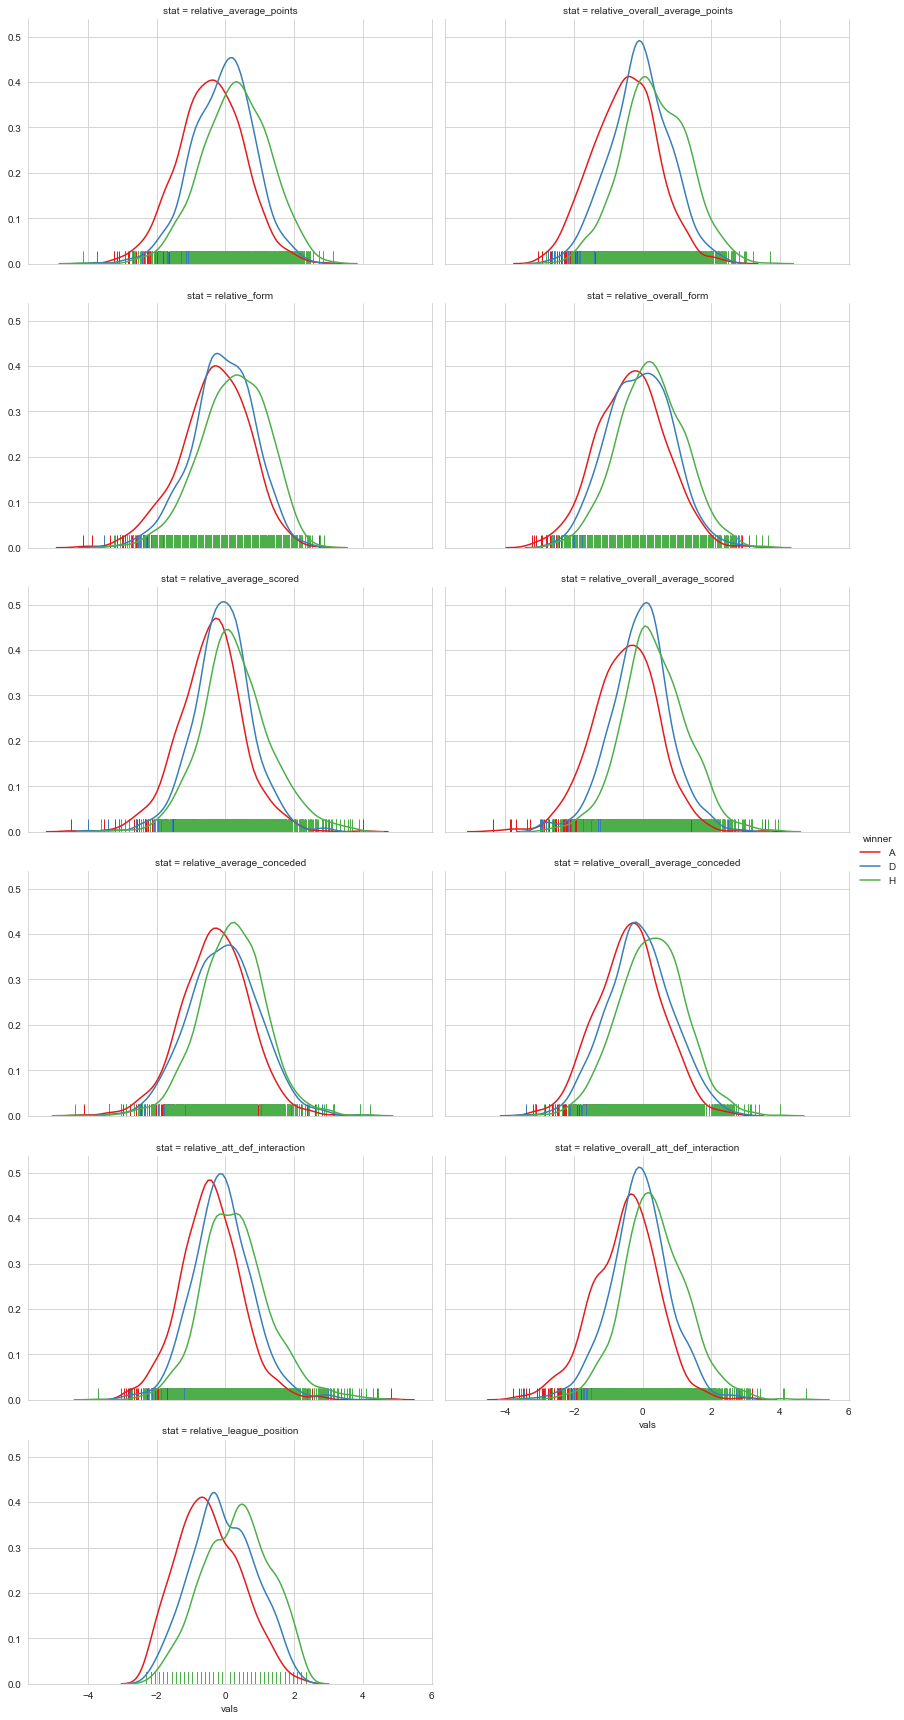

In [17]:
df = scaled_data.melt(['winner'], var_name='stat',  value_name='vals')
g = sns.FacetGrid(df, col='stat', hue='winner', palette='Set1', col_wrap=2, height=4, aspect=1.5)
g = (g.map(sns.distplot, "vals", hist=False, rug=True))
g.add_legend()

All of the features provide a marginal difference in distribution of the result but not enough to be a conclusive estimator. I also want see how the other features are correlated with each other.

In [18]:
scaled_data = pd.concat(
    [scaled_data.reset_index(drop=True), prem_fixtures['relative_score'].reset_index(drop=True)],
    axis=1)
home_away_dep_columns = [
    'relative_average_points',
    'relative_form',
    'relative_average_scored',
    'relative_average_conceded',
    'relative_att_def_interaction',
    'relative_score',
    'winner'
]
overall_columns = [
    'relative_overall_average_points',
    'relative_overall_form',
    'relative_overall_average_scored',
    'relative_overall_average_conceded',
    'relative_overall_att_def_interaction',
    'relative_league_position',
    'relative_score',
    'winner'
]

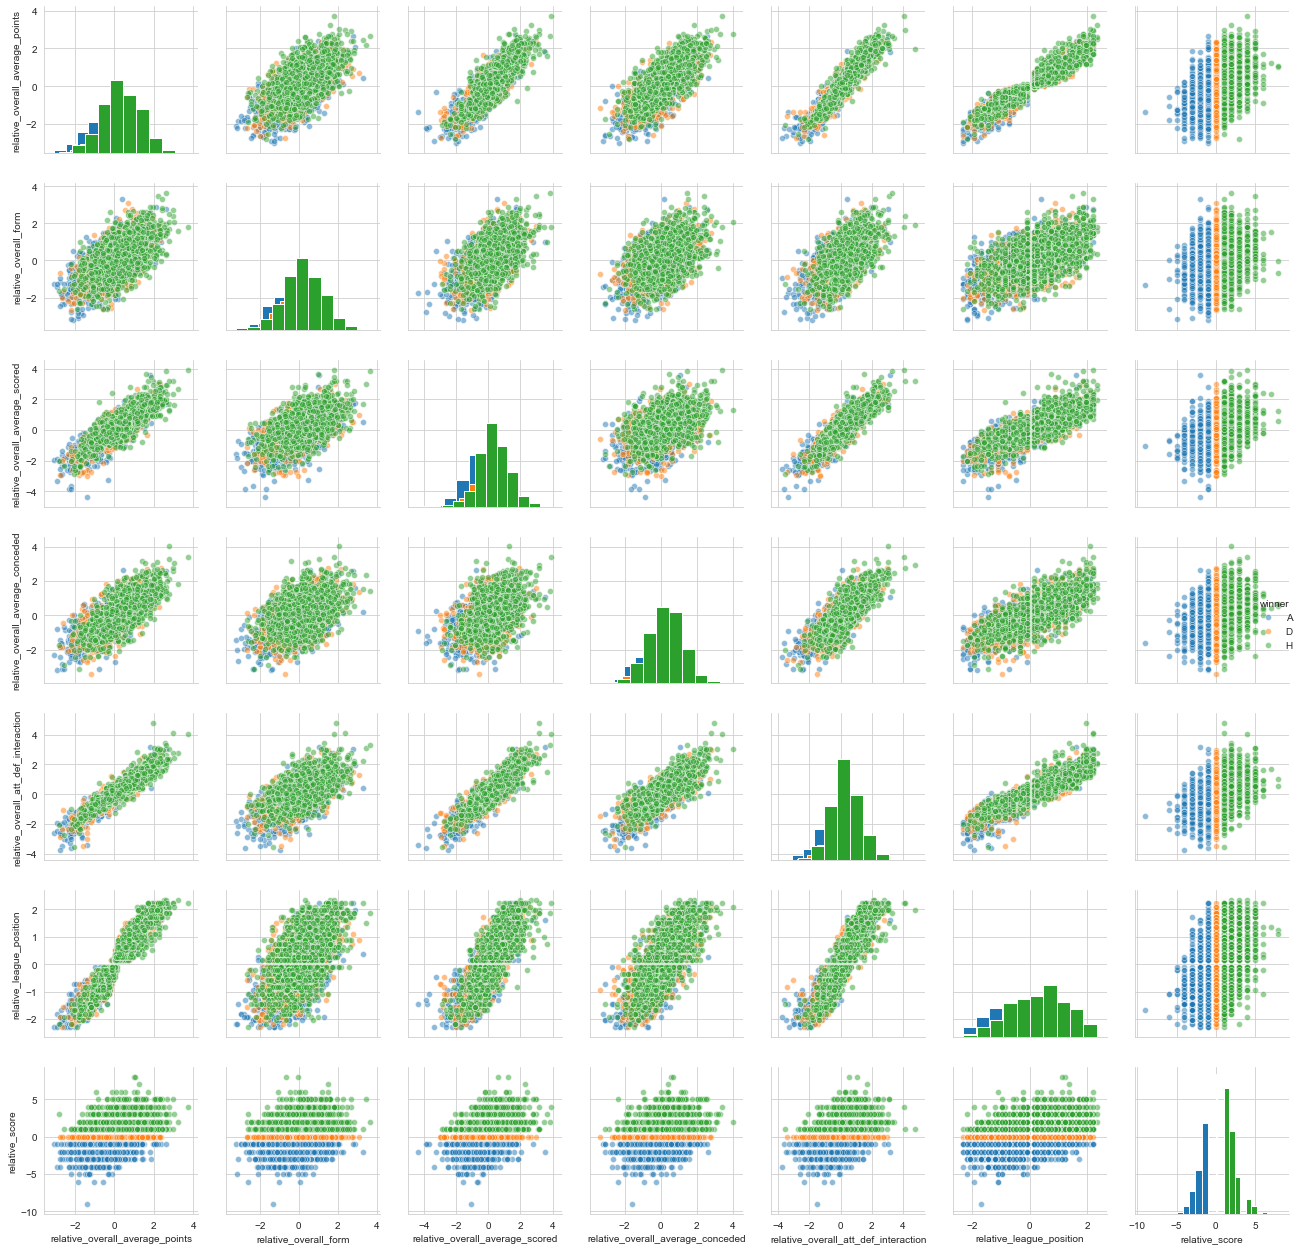

In [19]:
sns.pairplot(scaled_data[overall_columns], hue='winner', diag_kind='hist', plot_kws={'alpha': 0.5})
plt.tight_layout()

It is not advantageous to the modeling that a lot of the predictors seem to have a fair amount of correlation with each other as each feature on it's own doesn't provide a clear estimation of result.

## Predict relative score

I am interested to know if predicting the score using a machine learning algorithm could provide the model to predict the result with more certainty. First, lets create a set of predictors and a target variable.

In [20]:
# Predictors to use
relative_columns.remove('winner')

In [21]:
# Create predictor set and target
X = prem_fixtures[relative_columns]
y = prem_fixtures['relative_score']

In [22]:
# Scale the data
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=relative_columns)

In [23]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

I will train a linear regression and then use ridge and lasso to try to improve the model's performance, using a grid search to find an optimal value for alpha.

In [24]:
# Train linear regression
lin_reg = LinearRegression()
MSEs = cross_val_score(lin_reg, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
mean_MSE = abs(np.mean(MSEs))
print(mean_MSE)

2.7101504530583886


In [25]:
# Train lasso
lasso = Lasso(max_iter=10000)
parameters = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20]}
lasso_reg = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv=5)
lasso_reg.fit(X_train, y_train)
print(lasso_reg.best_params_)
print(abs(lasso_reg.best_score_))

{'alpha': 0.001}
2.7095473897059077


In [26]:
# Train ridge
ridge = Ridge(max_iter=10000)
parameters = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20, 40, 60, 80]}
ridge_reg = GridSearchCV(ridge, parameters, scoring='neg_mean_squared_error', cv=5)
ridge_reg.fit(X_train, y_train)
print(ridge_reg.best_params_)
print(abs(ridge_reg.best_score_))

{'alpha': 40}
2.7093393787499545


The ridge regresion model seems to give the best results (marginally). Let's take a closer look at this model.

In [27]:
ridge = ridge_reg.best_estimator_

# Model evaluation
predictions = ridge.predict(X_test)
print('RMSE: ', np.sqrt(mean_squared_error(y_test, predictions)))
print('MAE: ', mean_absolute_error(y_test, predictions))

RMSE:  1.6633704154911886
MAE:  1.278915630489068


I will now make some visualisations to show the models performance.

Text(0.5, 0, 'Residual Distribution')

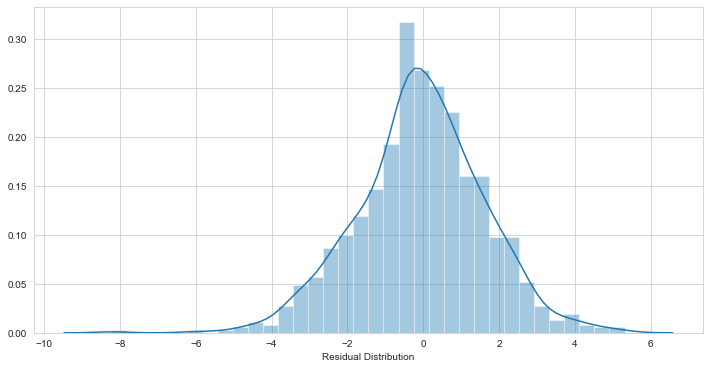

In [28]:
residuals = y_test - predictions
plt.figure(figsize=(12, 6))
sns.distplot(residuals)
plt.xlabel('Residual Distribution')

Text(0, 0.5, 'Prediction')

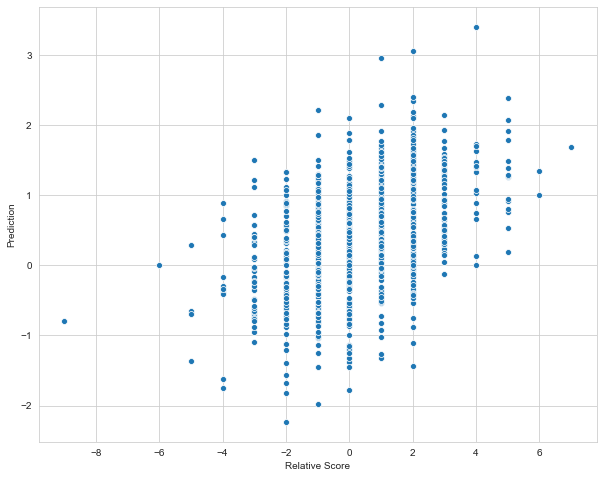

In [29]:
plt.figure(figsize=(10,8))
sns.scatterplot(y_test, predictions)
plt.xlabel('Relative Score')
plt.ylabel('Prediction')

Clearly the model leaves something to be desired with the accuracy but this can be a useful way to include the degree of the result in our model, i.e. a 6-0 win is a better win than a 1-0 win. The model tends to predict results that are much closer than the reality and a large proportion of the time predicts that the wrong team scores more goals but I can still investigate if this prediction adds any value to a result predicting model.

In [30]:
# Predict relative score for all results
X['predicted_relative_score'] = ridge.predict(X)

## Train ordinal classifier

As the results have an order a better model will likley be produced by including this information when training the model. This ordinal classifier should help to identify the order of results.

In [33]:
class OrdinalClassifier():

    def __init__(self, clf):
        self.clf = clf
        self.clfs = {}

    def fit(self, X, y):
        self.unique_class = np.sort(np.unique(y))
        if self.unique_class.shape[0] > 2:
            for i in range(self.unique_class.shape[0]-1):
                # for each k - 1 ordinal value we fit a binary classification
                # problem
                binary_y = (y > self.unique_class[i]).astype(np.uint8)
                clf = clone(self.clf)
                clf.fit(X, binary_y)
                self.clfs[i] = clf

    def predict_proba(self, X):
        clfs_predict = {k: self.clfs[k].predict_proba(X) for k in self.clfs}
        predicted = []
        for i, y in enumerate(self.unique_class):
            if i == 0:
                # V1 = 1 - Pr(y > V1)
                predicted.append(1 - clfs_predict[y][:, 1])
            elif y in clfs_predict:
                # Vi = Pr(y > Vi-1) - Pr(y > Vi)
                predicted.append(
                    clfs_predict[y-1][:, 1] - clfs_predict[y][:, 1])
            else:
                # Vk = Pr(y > Vk-1)
                predicted.append(clfs_predict[y-1][:, 1])
        return np.vstack(predicted).T

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

In [89]:
# Target variable
y = prem_fixtures['winner'].reset_index(drop=True)
X_A = X.drop('predicted_relative_score', axis=1)

discrete_map = {'A': 0, 'D': 1, 'H': 2}
y = y.map(discrete_map)

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
X_A_train, X_A_test, y_train, y_test = train_test_split(X_A, y, test_size=0.25, random_state=42, stratify=y)

In [84]:
# Logistic Regression
log_reg = LogisticRegression()
log_ord_classifier = OrdinalClassifier(log_reg)
log_ord_classifier.fit(X_train, y_train)

predictions = log_ord_classifier.predict(X_test)
print(f'Accuracy: {100 * accuracy_score(y_test, predictions):.2f}%')
print('\n')
print(pd.DataFrame(confusion_matrix(y_test, predictions)))
print('\n\n')
print(classification_report(y_test, predictions))

Accuracy: 53.75%


     0  1    2
0  109  0  116
1   55  0  132
2   55  0  307



              precision    recall  f1-score   support

           0       0.50      0.48      0.49       225
           1       0.00      0.00      0.00       187
           2       0.55      0.85      0.67       362

    accuracy                           0.54       774
   macro avg       0.35      0.44      0.39       774
weighted avg       0.40      0.54      0.46       774



/Users/nickhill/.virtualenvs/berlin_airbnb/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The model is predicting 53.75% of the results correctly. This is a decent result but we can see that the model never predicts a draw. This is understandable as the model is predicting the most likely result and a draw is the result that happens the least and is also not as seperable between win and loss.

In [85]:
# SVC
lin_svc =  SVC(probability=True)
lin_svc_ord_classifier = OrdinalClassifier(lin_svc)
lin_svc_ord_classifier.fit(X_train, y_train)

predictions = lin_svc_ord_classifier.predict(X_test)
print(f'Accuracy: {100 * accuracy_score(y_test, predictions):.2f}%')
print('\n')
print(pd.DataFrame(confusion_matrix(y_test, predictions)))
print('\n\n')
print(classification_report(y_test, predictions))

Accuracy: 47.80%


    0    1    2
0  78   70   77
1  31   65   91
2  26  109  227



              precision    recall  f1-score   support

           0       0.58      0.35      0.43       225
           1       0.27      0.35      0.30       187
           2       0.57      0.63      0.60       362

    accuracy                           0.48       774
   macro avg       0.47      0.44      0.44       774
weighted avg       0.50      0.48      0.48       774



In [86]:
# Naive Bayes
bayes = BernoulliNB()
bayes_ord_classifier = OrdinalClassifier(bayes)
bayes_ord_classifier.fit(X_train, y_train)

predictions = bayes_ord_classifier.predict(X_test)
print(f'Accuracy: {100 * accuracy_score(y_test, predictions):.2f}%')
print('\n')
print(pd.DataFrame(confusion_matrix(y_test, predictions)))
print('\n\n')
print(classification_report(y_test, predictions))

Accuracy: 48.58%


     0   1    2
0  147   9   69
1   91   9   87
2  121  21  220



              precision    recall  f1-score   support

           0       0.41      0.65      0.50       225
           1       0.23      0.05      0.08       187
           2       0.59      0.61      0.60       362

    accuracy                           0.49       774
   macro avg       0.41      0.44      0.39       774
weighted avg       0.45      0.49      0.44       774



In [87]:
# Random Forest
forest = RandomForestClassifier()
forest_ord_classifier = OrdinalClassifier(forest)
forest_ord_classifier.fit(X_train, y_train)

predictions = forest_ord_classifier.predict(X_test)
print(f'Accuracy: {100 * accuracy_score(y_test, predictions):.2f}%')
print('\n')
print(pd.DataFrame(confusion_matrix(y_test, predictions)))
print('\n\n')
print(classification_report(y_test, predictions))

Accuracy: 49.22%


     0   1    2
0  103  19  103
1   62  16  109
2   71  29  262



              precision    recall  f1-score   support

           0       0.44      0.46      0.45       225
           1       0.25      0.09      0.13       187
           2       0.55      0.72      0.63       362

    accuracy                           0.49       774
   macro avg       0.41      0.42      0.40       774
weighted avg       0.45      0.49      0.45       774



None of the classifiers perform to a particularly high accuracy, with the logistic regression model having the best accuracy although this model never predicts a draw. To increase the accuracy it could be beneficial to create more features to try and seperate the results more effectively. To improve the results it might be beneficial to calculate:

- Head to head results. Some teams typically underperform against certain teams, including how teams have performed against one another in previous games could help to identify who would win.

All of the models struggle to predict draws correctly. To have a good betting strategy it may be better to just calculate the liklihood of a team winning a match (grouping draw and loss as the same result). Here we could formulate the data differently, by having each game twice in our data set from each teams perspective.